In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False


 ![nn](머신러닝파이프라인.png)

#### 우리는 Feature Engineering 까지 끝난 상황이고, Data validation과정에서 imbalanced data set이라 이걸 어떻게 처리할 수 있을까를 고민하는 거에요

아래 과정은 정답이 아니라 제가 진행한 과정이에요
다음과 같은 과정을 통해서 Model의 성능(F1-Score)을 최대한 올리기 위한 방법입니다.
원래는 이렇게 해도 안나오면 위의 사진에서 Data analysis과정으로 돌아가야 해요

### 모델 선정
 #### 1. model hyper parmeter
 #### 2. Data OverSampling
 #### 3. threshold set
 #### 4. cross validation
 #### 5. another model

#### 1. model hyper parameter는 진행하지 않았습니다.
직접 해보실때 GridSearch로 각 모델의 최적 파라미터 넣으시면 대량 1% ~ 5%까지 성능 올리실 수 있습니다.

### Data load

In [7]:

df = pd.read_csv('/home/piai/빅데이터프로젝트/df_raw_new.csv')
### unused data del
df.drop(['환자ID', '수술일자','입원일자','퇴원일자'], axis=1, inplace=True)

### Encoding
 - Categorical data :One-hot-Encoding
 - sklearn : func get_dummies

In [8]:
### 더미화
df_dummy = pd.get_dummies(df)
df_y = df_dummy['수술실패여부']
df_x = df_dummy.drop(columns='수술실패여부')

### Standardization
 - scaler : MinMaxScaler
 - BinaryClassification : [0,1]

In [9]:
### 표준화
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_x)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = df_x.columns

### Split Data 
 - Train : 0.7
 - Test : 0.3

In [10]:
### train, test set divide
from sklearn.model_selection import train_test_split
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=1234, shuffle=True)

### Data Shape
 - Origin data

In [11]:
print('SMOTE 적용 전 트레인 피처/레이블 데Cross Validation이터 세트: ', df_train_x.shape, df_train_y.shape)
print('SMOTE 적용 전 테스트 피처/레이블 데이터 세트: ', df_test_x.shape, df_test_y.shape)
print('SMOTE 적용 전 레이블 값 분포:\n', pd.Series(df_train_y).value_counts())

SMOTE 적용 전 트레인 피처/레이블 데Cross Validation이터 세트:  (1292, 46) (1292,)
SMOTE 적용 전 테스트 피처/레이블 데이터 세트:  (554, 46) (554,)
SMOTE 적용 전 레이블 값 분포:
 0    1215
1      77
Name: 수술실패여부, dtype: int64


### Model Function 
 - modeling() - model set
 - metrics() - evaluation metrics & confusion matrix

In [13]:
def modeling(model,x_train,x_test,y_train,y_test):
    model.fit(x_train,y_train)
    pred = model.predict(x_test)
    metrics(y_test,pred)
    
    
def metrics(y_test,pred):
    matrix = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred,average='macro')
    print(matrix)
    print('정확도 : {0:.4f}\n정밀도 : {1:.4f}\n재현율 : {2:.4f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.4f}\nauc : {1:.4f}'.format(f1,roc_score))
    return accuracy, precision, recall,f1

### Model Compare : Origin Data
 - Linear Regression
 - Decision Tree
 - RandomForest
 - LightGBM
 - CatBoost
 - AdaBoost
 - Gradient Boost
 - XGBoost

In [14]:
train_score=[];test_score=[]

print('\nLR')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
result_lr = modeling(lr, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(lr.score(df_train_x,df_train_y))
test_score.append(lr.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, lr.predict(df_train_x)))

print('\nDT')
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(max_depth=1, min_samples_split=10, min_samples_leaf=6, random_state=1234)
result_dt = modeling(DT, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(DT.score(df_train_x,df_train_y))
test_score.append(DT.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, DT.predict(df_train_x)))

print('\nRF')
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=15, n_estimators=70, random_state=1234)
RF.fit(df_train_x, df_train_y)
result_rf= modeling(RF,  df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(RF.score(df_train_x,df_train_y))
test_score.append(RF.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, RF.predict(df_train_x)))

print('\nLGB')
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False, random_state=1234)
result_lgb = modeling(lgb, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(lgb.score(df_train_x,df_train_y))
test_score.append(lgb.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, lgb.predict(df_train_x)))

print('\ncatboost')
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=10, learning_rate=0.5,random_state=1234 )
result_cat = modeling(cat, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(cat.score(df_train_x,df_train_y))
test_score.append(cat.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, cat.predict(df_train_x)))

print('\nada')
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=1234)
result_ada = modeling(ada, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(ada.score(df_train_x,df_train_y))
test_score.append(ada.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, ada.predict(df_train_x)))

print('\nGB')
from sklearn.ensemble import GradientBoostingClassifier
gra = GradientBoostingClassifier(random_state = 1234)
result_gra = modeling(gra, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(gra.score(df_train_x,df_train_y))
test_score.append(gra.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, gra.predict(df_train_x)))

print('\nXGB')
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, learning_rate =0.1, random_state = 1234)
result_xgb = modeling(xgb, df_train_x, df_test_x, df_train_y, df_test_y)
train_score.append(xgb.score(df_train_x,df_train_y))
test_score.append(xgb.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(df_train_y, xgb.predict(df_train_x)))


LR
[[516   0]
 [ 38   0]]
정확도 : 0.9314
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.5000
Train F1_SCORE :  0.0

DT
[[515   1]
 [ 38   0]]
정확도 : 0.9296
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.4990
Train F1_SCORE :  0.15555555555555556

RF
[[516   0]
 [ 38   0]]
정확도 : 0.9314
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.5000
Train F1_SCORE :  0.9733333333333333

LGB
[[514   2]
 [ 23  15]]
정확도 : 0.9549
정밀도 : 0.8824
재현율 : 0.3947
f1-score : 0.5455
auc : 0.6954
Train F1_SCORE :  1.0

catboost
0:	learn: 0.3023372	total: 51.1ms	remaining: 460ms
1:	learn: 0.2300172	total: 57ms	remaining: 228ms
2:	learn: 0.1948305	total: 66.3ms	remaining: 155ms
3:	learn: 0.1830292	total: 74.6ms	remaining: 112ms
4:	learn: 0.1689879	total: 81.3ms	remaining: 81.3ms
5:	learn: 0.1574596	total: 83.8ms	remaining: 55.9ms
6:	learn: 0.1426843	total: 86.5ms	remaining: 37.1ms
7:	learn: 0.1317481	total: 90.4ms	remaining: 22.6ms
8:	learn: 0.1193250	total: 94.7ms	remaining: 10.5ms
9:	learn: 0.1104119	

### oversampling  예시

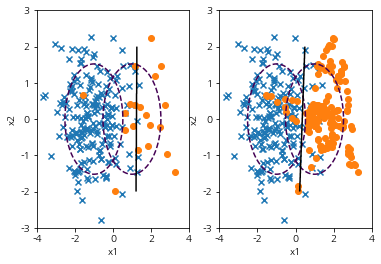

In [16]:
from imblearn.over_sampling import SMOTE
import scipy as sp
from sklearn.svm import SVC
def classification_result2(X, y, title=""):
    plt.contour(X1, X2, rv1.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    plt.contour(X1, X2, rv2.pdf(np.dstack([X1, X2])), levels=[0.05], linestyles="dashed")
    model = SVC(kernel="linear", C=1e4, random_state=0).fit(X, y)
    Y = np.reshape(model.predict(np.array([X1.ravel(), X2.ravel()]).T), X1.shape)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], marker='x', label="0 클래스")
    plt.scatter(X[y == 1, 0], X[y == 1, 1], marker='o', label="1 클래스")
    plt.contour(X1, X2, Y, colors='k', levels=[0.5])
    y_pred = model.predict(X)
    plt.xlim(-4, 4)
    plt.ylim(-3, 3)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    return model
n0 = 200; n1 = 20
rv1 = sp.stats.multivariate_normal([-1, 0], [[1, 0], [0, 1]])
rv2 = sp.stats.multivariate_normal([+1, 0], [[1, 0], [0, 1]])
X0 = rv1.rvs(n0, random_state=0)
X1 = rv2.rvs(n1, random_state=0)
X_imb = np.vstack([X0, X1])
y_imb = np.hstack([np.zeros(n0), np.ones(n1)])
X_samp, y_samp = SMOTE(random_state=4).fit_resample(X_imb, y_imb)
x1min = -4; x1max = 4
x2min = -2; x2max = 2
xx1 = np.linspace(x1min, x1max, 1000)
xx2 = np.linspace(x2min, x2max, 1000)
X1, X2 = np.meshgrid(xx1, xx2)


plt.subplot(121)
classification_result2(X_imb, y_imb)

plt.subplot(122)
model_samp = classification_result2(X_samp, y_samp)

### 1. Oversampling
 #### - SMOTE METHOD

In [18]:
from imblearn.over_sampling import SMOTE
sm_train_x,sm_train_y = SMOTE(random_state=1234).fit_resample(df_train_x,df_train_y)


#적용전
print('SMOTE 적용 전 트레인 피처/레이블 데이터 세트: ', df_train_x.shape, df_train_y.shape)
print('SMOTE 적용 전 테스트 피처/레이블 데이터 세트: ', df_test_x.shape, df_test_y.shape)
print('SMOTE 적용 전 레이블 값 분포: \n', pd.Series(df_train_y).value_counts())
print('-'*80)
#적용후
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', sm_train_x.shape, sm_train_y.shape)
#print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', sm_train_x.shape, sm_train_y.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(sm_train_y).value_counts())

SMOTE 적용 전 트레인 피처/레이블 데이터 세트:  (1292, 46) (1292,)
SMOTE 적용 전 테스트 피처/레이블 데이터 세트:  (554, 46) (554,)
SMOTE 적용 전 레이블 값 분포: 
 0    1215
1      77
Name: 수술실패여부, dtype: int64
--------------------------------------------------------------------------------
SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (2430, 46) (2430,)
SMOTE 적용 후 레이블 값 분포: 
 1    1215
0    1215
Name: 수술실패여부, dtype: int64


In [19]:
train_score=[];test_score=[]

print('\nLR')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
result_lr = modeling(lr, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(lr.score(sm_train_x,sm_train_y))
test_score.append(lr.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, lr.predict(sm_train_x)))

print('\nDT')
from sklearn.tree import DecisionTreeClassifier
DT = DecisionTreeClassifier(max_depth=1, min_samples_split=10, min_samples_leaf=6, random_state=1234)
result_dt = modeling(DT, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(DT.score(sm_train_x,sm_train_y))
test_score.append(DT.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, DT.predict(sm_train_x)))

print('\nRF')
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(max_depth=15, n_estimators=70, random_state=1234)
RF.fit(sm_train_x, sm_train_y)
result_rf= modeling(RF,  sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(RF.score(sm_train_x,sm_train_y))
test_score.append(RF.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, RF.predict(sm_train_x)))

print('\nLGB')
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False, random_state=1234)
result_lgb = modeling(lgb, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(lgb.score(sm_train_x,sm_train_y))
test_score.append(lgb.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, lgb.predict(sm_train_x)))

print('\ncatboost')
from catboost import CatBoostClassifier
cat = CatBoostClassifier(iterations=10, learning_rate=0.5,random_state=1234 )
result_cat = modeling(cat, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(cat.score(sm_train_x,sm_train_y))
test_score.append(cat.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, cat.predict(sm_train_x)))

print('\nada')
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=1234)
result_ada = modeling(ada, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(ada.score(sm_train_x,sm_train_y))
test_score.append(ada.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, ada.predict(sm_train_x)))

print('\nGB')
from sklearn.ensemble import GradientBoostingClassifier
gra = GradientBoostingClassifier(random_state = 1234)
result_gra = modeling(gra, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(gra.score(sm_train_x,sm_train_y))
test_score.append(gra.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, gra.predict(sm_train_x)))

print('\nXGB')
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=500, learning_rate =0.1, random_state = 1234)
result_xgb = modeling(xgb, sm_train_x, df_test_x, sm_train_y, df_test_y)
train_score.append(xgb.score(sm_train_x,sm_train_y))
test_score.append(xgb.score(df_test_x,df_test_y))
print("Train F1_SCORE : ", f1_score(sm_train_y, xgb.predict(sm_train_x)))


LR
[[301 215]
 [ 19  19]]
정확도 : 0.5776
정밀도 : 0.0812
재현율 : 0.5000
f1-score : 0.1397
auc : 0.5417
Train F1_SCORE :  0.6161776367961936

DT
[[198 318]
 [ 12  26]]
정확도 : 0.4043
정밀도 : 0.0756
재현율 : 0.6842
f1-score : 0.1361
auc : 0.5340
Train F1_SCORE :  0.713670969877524

RF
[[502  14]
 [ 38   0]]
정확도 : 0.9061
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.4864
Train F1_SCORE :  0.9983566146261299

LGB
[[514   2]
 [ 31   7]]
정확도 : 0.9404
정밀도 : 0.7778
재현율 : 0.1842
f1-score : 0.2979
auc : 0.5902
Train F1_SCORE :  1.0

catboost
0:	learn: 0.5002260	total: 4.12ms	remaining: 37.1ms
1:	learn: 0.4162392	total: 27.9ms	remaining: 112ms
2:	learn: 0.3686754	total: 37.8ms	remaining: 88.3ms
3:	learn: 0.3233832	total: 50.6ms	remaining: 75.9ms
4:	learn: 0.2794776	total: 63.6ms	remaining: 63.6ms
5:	learn: 0.2610914	total: 81.8ms	remaining: 54.5ms
6:	learn: 0.2242224	total: 90.2ms	remaining: 38.6ms
7:	learn: 0.1996747	total: 124ms	remaining: 31ms
8:	learn: 0.1726046	total: 152ms	remaining: 16.9ms
9:	lea


### - 대안
 #### 1. Data OverSampling 
 #### 2. threshold set
 
 
 #### 3. model hyper parmeter
 #### 4. cross validation
 #### 5. another model


### 2. Threshold set
 - Threshold Funtion
 - get_eval_by_threshold : find Threshold 

In [21]:
from sklearn.preprocessing import Binarizer
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    print('오차 행렬')
    print(confusion)
    print(' 정밀도: {0:.4f}, 재현율: {1:.4f}'.format(precision ,recall))
# 임계값 조정
thresholds = [0.40, 0.45, 0.50, 0.55, 0.60]
def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds list객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        metrics(y_test , custom_predict)
        #get_clf_eval(y_test , custom_predict)
        print('-'*20)


In [23]:
### RandomForest
pred_proba = RF.predict_proba(df_test_x)
get_eval_by_threshold(df_test_y ,pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
[[485  31]
 [ 32   6]]
정확도 : 0.8863
정밀도 : 0.1622
재현율 : 0.1579
f1-score : 0.1600
auc : 0.5489
--------------------
임곗값: 0.45
[[499  17]
 [ 35   3]]
정확도 : 0.9061
정밀도 : 0.1500
재현율 : 0.0789
f1-score : 0.1034
auc : 0.5230
--------------------
임곗값: 0.5
[[502  14]
 [ 38   0]]
정확도 : 0.9061
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.4864
--------------------
임곗값: 0.55
[[508   8]
 [ 38   0]]
정확도 : 0.9170
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.4922
--------------------
임곗값: 0.6
[[512   4]
 [ 38   0]]
정확도 : 0.9242
정밀도 : 0.0000
재현율 : 0.0000
f1-score : 0.0000
auc : 0.4961
--------------------


In [24]:
lgb2 = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,is_unbalance = True,boost_from_average=False)
modeling(lgb2,sm_train_x, df_test_x, sm_train_y, df_test_y)

[[514   2]
 [ 31   7]]
정확도 : 0.9404
정밀도 : 0.7778
재현율 : 0.1842
f1-score : 0.2979
auc : 0.5902


In [25]:
### lightGBM
pred_proba2 = lgb2.predict_proba(df_test_x)
get_eval_by_threshold(df_test_y ,pred_proba2[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
[[512   4]
 [ 31   7]]
정확도 : 0.9368
정밀도 : 0.6364
재현율 : 0.1842
f1-score : 0.2857
auc : 0.5882
--------------------
임곗값: 0.45
[[512   4]
 [ 31   7]]
정확도 : 0.9368
정밀도 : 0.6364
재현율 : 0.1842
f1-score : 0.2857
auc : 0.5882
--------------------
임곗값: 0.5
[[514   2]
 [ 31   7]]
정확도 : 0.9404
정밀도 : 0.7778
재현율 : 0.1842
f1-score : 0.2979
auc : 0.5902
--------------------
임곗값: 0.55
[[515   1]
 [ 31   7]]
정확도 : 0.9422
정밀도 : 0.8750
재현율 : 0.1842
f1-score : 0.3043
auc : 0.5911
--------------------
임곗값: 0.6
[[515   1]
 [ 32   6]]
정확도 : 0.9404
정밀도 : 0.8571
재현율 : 0.1579
f1-score : 0.2667
auc : 0.5780
--------------------


In [26]:
### xgb### xgb
pred_proba = xgb.predict_proba(df_test_x)
#print(pred_proba)
get_eval_by_threshold(df_test_y ,pred_proba[:,1].reshape(-1,1), thresholds)
pred_proba = xgb.predict_proba(df_test_x)
#print(pred_proba)
get_eval_by_threshold(df_test_y ,pred_proba[:,1].reshape(-1,1), thresholds)

임곗값: 0.4
[[507   9]
 [ 28  10]]
정확도 : 0.9332
정밀도 : 0.5263
재현율 : 0.2632
f1-score : 0.3509
auc : 0.6229
--------------------
임곗값: 0.45
[[509   7]
 [ 29   9]]
정확도 : 0.9350
정밀도 : 0.5625
재현율 : 0.2368
f1-score : 0.3333
auc : 0.6116
--------------------
임곗값: 0.5
[[511   5]
 [ 30   8]]
정확도 : 0.9368
정밀도 : 0.6154
재현율 : 0.2105
f1-score : 0.3137
auc : 0.6004
--------------------
임곗값: 0.55
[[513   3]
 [ 30   8]]
정확도 : 0.9404
정밀도 : 0.7273
재현율 : 0.2105
f1-score : 0.3265
auc : 0.6024
--------------------
임곗값: 0.6
[[514   2]
 [ 31   7]]
정확도 : 0.9404
정밀도 : 0.7778
재현율 : 0.1842
f1-score : 0.2979
auc : 0.5902
--------------------
임곗값: 0.4
[[507   9]
 [ 28  10]]
정확도 : 0.9332
정밀도 : 0.5263
재현율 : 0.2632
f1-score : 0.3509
auc : 0.6229
--------------------
임곗값: 0.45
[[509   7]
 [ 29   9]]
정확도 : 0.9350
정밀도 : 0.5625
재현율 : 0.2368
f1-score : 0.3333
auc : 0.6116
--------------------
임곗값: 0.5
[[511   5]
 [ 30   8]]
정확도 : 0.9368
정밀도 : 0.6154
재현율 : 0.2105
f1-score : 0.3137
auc : 0.6004
--------------------
임곗값: 0.55
[[5

cross validation은 xgboost는 파라미터로 설정할 수 있고
나머지는 K-fold 교차 검증 

 ![nn](k-fold.png)

### 재발여부 모델도 위와 동일